In [1]:
import networkx as nx
import json
import glob
import os
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.utils.outcome_params import engel_score
from epilepsypcm.utils.outcome_params import seizure_onset_zone, engel_score

In [2]:
base_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/'

patient_files = os.listdir(base_path)
positive_dataframes = []
response_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/PY16N008/ResponseInfo/CCEP'
response_files_path = response_files_path = glob.glob(response_path + '/*.json', recursive=True)
respFile = response_files_path[0]
print(respFile.split("_"))


['/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/PY16N008/ResponseInfo/CCEP/PY16N008', 'RPTI26', 'RPTI27', '5ma', 'ResponseInfo.json']


In [11]:
data = json.load(open(response_files_path[0]))
for key in data['time']: print(key)

RATS1_RATS2
RATS2_RATS3
RATS3_RATS4
RATI1_RATI2
RATI2_RATI3
RATI3_RATI4
RATI4_RATI5
RATI5_RATI6
RATI6_RATI7
RATI7_RATI8
RATI9_RATI10
RATI10_RATI11
RATI11_RATI12
RATI12_RATI13
RATI13_RATI14
RATI14_RATI15
RATI15_RATI16
RABT1_RABT2
RABT2_RABT3
RABT3_RABT4
RMBT1_RMBT2
RMBT2_RMBT3
RMBT3_RMBT4
RPTI17_RPTI18
RPTI18_RPTI19
RPTI19_RPTI20
RPTI20_RPTI21
RPTI21_RPTI22
RPTI22_RPTI23
RPTI23_RPTI24
RPTI25_RPTI26
RPTI26_RPTI27
RPTI27_RPTI28
RPTI28_RPTI29
RPTI29_RPTI30
RPTI30_RPTI31
RPTI31_RPTI32
RPTS49_RPTS50
RPTS50_RPTS51
RPTS51_RPTS52
RPTS52_RPTS53
RPTS53_RPTS54
RPTS54_RPTS55
RPTS55_RPTS56
RPTS57_RPTS58
RPTS58_RPTS59
RPTS59_RPTS60
RPTS60_RPTS61
RPTS61_RPTS62
RPTS62_RPTS63
RPTS63_RPTS64
RPFS1_RPFS2
RPFS2_RPFS3
RPFS3_RPFS4
RPFS4_RPFS5
RPFS5_RPFS6
RPFS6_RPFS7
RPFS7_RPFS8
RPFI1_RPFI2
RPFI2_RPFI3
RPFI3_RPFI4
Fp1_Fp2
TA71_TA82
C3_C4
O1_O2


In [91]:
def make_df_forNetwork(patient,paths):
    n = 0
    stimChs = []
    for i in range(len(paths)):
        chNames = []
        # load info into python dictionary
        data = json.load(open(paths[i]))

        # Get list of channel names
        for key in data["time"]: chNames.append(key)
        
        if n < 1:
            significant = np.empty((len(paths), len(chNames)))
            n1Zscore = np.empty((len(paths), len(chNames)))
            n2Zscore = np.empty((len(paths), len(chNames)))
            p2Zscore = np.empty((len(paths), len(chNames)))
            n1Latency = np.empty((len(paths), len(chNames)))
            n2Latency = np.empty((len(paths), len(chNames)))
            #p2Latency = np.empty((len(paths), len(chNames)))
            n += 1
            samplingRate = np.empty((len(paths)))
            window = np.empty((len(paths), 2))
        
        for j in range(len(chNames)):
            significant[i][j] = data['significant'][chNames[j]]
            n1Zscore[i][j] = data['zscores'][chNames[j]]['n1'][1]
            n2Zscore[i][j] = data['zscores'][chNames[j]]['n2'][1]
            p2Zscore[i][j] = data['zscores'][chNames[j]]['p2'][1]
            n1Latency[i][j] = data['zscores'][chNames[j]]['n1'][0] + data['window'][0] * data["samplingRate"] / 1000
            n2Latency[i][j] = data['zscores'][chNames[j]]['n2'][0] + data['window'][0] * data["samplingRate"] / 1000
            #p2Latency[i][j] = data['zscores'][chNames[j]]['p2'][0] + data['window'][0] * data["samplingRate"] / 1000
        
        stimChs = stimChs + [paths[i].split("_")[1] + "_" + paths[i].split("_")[2]]*len(chNames)

    df = pd.DataFrame()
    df["stimChs"] = stimChs
    df["respChs"] = chNames * len(paths)
    df["significant"] = significant.flatten()
    df["n1Zscore"] = abs(n1Zscore.flatten())
    df["n2Zscore"] = abs(n2Zscore.flatten())
    #df["p2Zscore"] = abs(p2Zscore.flatten())
    df["n1Latency"] = n1Latency.flatten()
    df["n2Latency"] = n2Latency.flatten()
    #df["p2Latency"] = p2Latency.flatten()
    
    df = df.drop(df.loc[df["n1Latency"] == -999.0].index)
    df = df.drop(df.loc[df["n1Latency"] == -499.0].index)

    df["InDegree"] = np.zeros(df.shape[0])
    df["OutDegree"] = np.zeros(df.shape[0])
    df["EV"] = np.zeros(df.shape[0])
    df["Closeness"] = np.zeros(df.shape[0])
    respChNames = df.respChs.unique()
    stimChNames = df.stimChs.unique()
    for channel in respChNames:
        df.loc[df.respChs == channel, 'InDegree'] = sum(df[df.respChs == channel].significant == 1)/len(stimChNames)
    for channel in stimChNames:
        df.loc[df.respChs == channel, 'OutDegree'] = sum(df[df.stimChs == channel].significant == 1)/len(respChNames)
    
    G = nx.DiGraph()
    for i in range(D.shape[0]):
        if df.significant.iloc[i] == 1:
            G.add_edge(df.stimChs.iloc[i],df.respChs.iloc[i])
    EV_Cent = nx.eigenvector_centrality(G)
    Closeness_Cent = nx.closeness_centrality(G)
    for channel in list(EV_Cent):
        df.loc[df.respChs == channel, 'EV'] = EV_Cent[channel]
    for channel in list(Closeness_Cent):
        df.loc[df.respChs == channel, 'Closeness'] = Closeness_Cent[channel]
        
    
    df["outcome"] = np.zeros(df.shape[0])
    if engel_score[patient] == "1":
        if seizure_onset_zone[patient] != "None":
            for node in seizure_onset_zone[patient]:
                for channel in df["respChs"]:
                    if node in channel:
                        #df["outcome"][df["chNames"] == channel] = 1
                        df.loc[df['respChs']==channel, ['outcome']] = 1
    

    return df


In [95]:
#Location
patient = patient_files[0]
response_path = base_path + patient + '/ResponseInfo/CCEP'
response_files_path = glob.glob(response_path + '/*.json', recursive=True)

D = make_df_forNetwork(patient,response_files_path)
print(patient)
#D[D.significant==1]
#D[D.outcome == 1][1:50]
#D[D.outcome == 1]
D[D.respChs=='LA7_LA8']

PY21N008


,stimChs,respChs,significant,n1Zscore,n2Zscore,n1Latency,n2Latency,InDegree,OutDegree,EV,Closeness,outcome
6,LFOA1_LFOA2,LA7_LA8,0.0,1.371992,1.735958,17.0,131.0,0.032258,0.0,2.801721e-12,0.014085,0.0
97,LPH5_LPH6,LA7_LA8,0.0,2.118024,4.094380,45.0,276.0,0.032258,0.0,2.801721e-12,0.014085,0.0
188,RA3_RA4,LA7_LA8,0.0,2.396175,2.557455,11.0,345.0,0.032258,0.0,2.801721e-12,0.014085,0.0
279,LBT6_LBT7,LA7_LA8,0.0,1.095832,1.460495,36.0,195.0,0.032258,0.0,2.801721e-12,0.014085,0.0
370,LPH1_LPH2,LA7_LA8,0.0,1.142550,4.597938,20.0,323.0,0.032258,0.0,2.801721e-12,0.014085,0.0
461,LOF1_LOF2,LA7_LA8,0.0,1.601891,0.035813,39.0,326.0,0.032258,0.0,2.801721e-12,0.014085,0.0
552,LAH1_LAH2,LA7_LA8,0.0,2.321048,1.013585,18.0,262.0,0.032258,0.0,2.801721e-12,0.014085,0.0
643,LBT1_LBT2,LA7_LA8,0.0,1.590386,1.470696,32.0,336.0,0.032258,0.0,2.801721e-12,0.014085,0.0
734,LIN10_LIN11,LA7_LA8,0.0,2.127278,1.000809,43.0,160.0,0.032258,0.0,2.801721e-12,0.014085,0.0
825,LAH8_LAH9,LA7_LA8,0.0,3.820126,1.618207,35.0,307.0,0.032258,0.0,2.801721e-12,0.014085,0.0


In [14]:
def concat_df(base_path, engel, balance = None):

    patient_files = os.listdir(base_path)

    full_df = pd.DataFrame()
    for file in patient_files:
        if (file[0] == "P") & (file != "PY16N006"):
            response_path = base_path + file + '/ResponseInfo/CCEP'
            response_files_path = glob.glob(response_path + '/*.json', recursive=True)

            # Getting individual dataframe for positive patients
            patient = file
            if file in engel_score.keys():  # if we currently have the file's engel score
                if engel_score[patient] == engel:  # if the engel score is 1
                    df = make_df_forNetwork(patient, response_files_path)
                    full_df = pd.concat([full_df, df])

    # seperate dataframes for class
    df_majority = full_df[full_df.outcome == 0]
    df_minority = full_df[full_df.outcome == 1]

    # upsample data if balance parameter is set to "Upsample" or "upsample"
    if (balance == "upsample") | (balance == "Upsample"):
        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,  # sample with replacement
                                         n_samples=full_df["outcome"].value_counts()[0.0],
                                         # to match majority class
                                         random_state=123)  # reproducible results


        # combine dataframes
        full_df = pd.concat([df_majority, df_minority_upsampled])

    # downsample data if balance parameter is set to "downsample" or "Downsample"
    elif (balance == "downsample") | (balance == "Downsample"):
        # downsample majority class
        # downsample majority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False,  # sample without replacement
                                           n_samples= full_df["outcome"].value_counts()[1.0],
                                           # to match minority class
                                           random_state=123)  # reproducible results


        full_df = pd.concat([df_majority_downsampled, df_minority])

    return full_df

In [15]:
base_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/' #modify for your file location
patient_files = os.listdir(base_path)
print(patient_files)
len(patient_files)

['PY21N008', 'PY21N006', 'PY20N001', 'PY21N007', 'PY17N020', 'PY18N007', 'PY17N018', '.DS_Store', 'PY16N011', 'PY19N009', 'PY17N019', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N024', 'PY18N015', 'PY18N013', 'PY17N005', 'PY21N014', 'PY21N022', 'PY20N012', 'PY21N012', 'PY20N002', 'PY20N005', 'PY21N002', 'PY20N003', 'PY21N004', 'PY18N003', 'PY19N005', 'PY16N013', 'PY17N013', 'PY17N014', 'PY18N002', '.ipynb_checkpoints', 'PY18N011', 'PY18N016', 'PY19N011', 'PY19N018', 'PY19N020', 'PY17N008', 'PY16N006', 'PY19N026', 'PY16N008', 'PY19N017', 'PY21N010', 'PY21N020', 'PY20N016', 'PY20N011']


48

In [71]:
all_positive_patients = concat_df(base_path, "1")
A = all_positive_patients
A

,stimChs,respChs,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,InDegree,OutDegree,outcome
2,LFOA1_LFOA2,LA3_LA4,0.0,1.396644,1.062212,5.025081,13.0,180.0,43.0,7.0,0.0,1.0
6,LFOA1_LFOA2,LA7_LA8,0.0,1.371992,1.735958,0.305671,17.0,131.0,47.0,1.0,0.0,0.0
7,LFOA1_LFOA2,LA8_LA9,0.0,1.990935,0.596185,0.596185,19.0,101.0,101.0,0.0,0.0,0.0
8,LFOA1_LFOA2,LA9_LA10,0.0,2.361205,1.335067,0.176026,11.0,101.0,43.0,0.0,20.0,1.0
9,LFOA1_LFOA2,LAH1_LAH2,0.0,0.901176,1.048693,1.308852,11.0,321.0,98.0,2.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
706,RPTS60_RPTS61,RPFS6_RPFS7,0.0,0.775927,2.579947,4.290270,51.0,285.0,195.0,3.0,0.0,0.0
707,RPTS60_RPTS61,RPFS7_RPFS8,0.0,1.769931,5.228859,3.093837,12.0,139.0,69.0,2.0,0.0,0.0
708,RPTS60_RPTS61,RPFI1_RPFI2,0.0,1.361718,2.097774,1.999799,14.0,338.0,278.0,2.0,0.0,0.0
709,RPTS60_RPTS61,RPFI2_RPFI3,0.0,2.863802,2.631576,7.996893,44.0,228.0,118.0,2.0,0.0,0.0


In [73]:
B = A[1:30]
B

,stimChs,respChs,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,InDegree,OutDegree,outcome
6,LFOA1_LFOA2,LA7_LA8,0.0,1.371992,1.735958,0.305671,17.0,131.0,47.0,1.0,0.0,0.0
7,LFOA1_LFOA2,LA8_LA9,0.0,1.990935,0.596185,0.596185,19.0,101.0,101.0,0.0,0.0,0.0
8,LFOA1_LFOA2,LA9_LA10,0.0,2.361205,1.335067,0.176026,11.0,101.0,43.0,0.0,20.0,1.0
9,LFOA1_LFOA2,LAH1_LAH2,0.0,0.901176,1.048693,1.308852,11.0,321.0,98.0,2.0,16.0,1.0
10,LFOA1_LFOA2,LAH2_LAH3,0.0,4.324042,4.524443,1.176967,16.0,101.0,45.0,4.0,0.0,1.0
11,LFOA1_LFOA2,LAH3_LAH4,0.0,4.214433,2.351241,1.154445,15.0,110.0,43.0,7.0,0.0,1.0
12,LFOA1_LFOA2,LAH4_LAH5,0.0,2.699702,1.516418,0.385466,17.0,101.0,60.0,6.0,0.0,0.0
13,LFOA1_LFOA2,LAH5_LAH6,0.0,2.995896,1.054070,0.265259,21.0,101.0,62.0,6.0,0.0,0.0
16,LFOA1_LFOA2,LAH8_LAH9,1.0,6.104519,2.992231,0.553621,15.0,101.0,43.0,9.0,7.0,0.0
17,LFOA1_LFOA2,LPH1_LPH2,0.0,0.165790,1.713810,0.736836,13.0,291.0,70.0,3.0,18.0,0.0


In [17]:
#Location
patient = patient_files[0]
response_path = base_path + patient + '/ResponseInfo/CCEP'
response_files_path = glob.glob(response_path + '/*.json', recursive=True)

D = make_df_forNetwork(patient,response_files_path)
print(patient)
#D[D.significant==1]
#D[D.outcome == 1][1:50]
#D[D.outcome == 1]
D

PY21N008


,stimChs,respChs,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,outcome
2,LFOA1_LFOA2,LA3_LA4,0.0,1.396644,1.062212,5.025081,13.0,180.0,43.0,1.0
6,LFOA1_LFOA2,LA7_LA8,0.0,1.371992,1.735958,0.305671,17.0,131.0,47.0,0.0
7,LFOA1_LFOA2,LA8_LA9,0.0,1.990935,0.596185,0.596185,19.0,101.0,101.0,0.0
8,LFOA1_LFOA2,LA9_LA10,0.0,2.361205,1.335067,0.176026,11.0,101.0,43.0,1.0
9,LFOA1_LFOA2,LAH1_LAH2,0.0,0.901176,1.048693,1.308852,11.0,321.0,98.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2816,LFOP3_LFOP4,RAH5_RAH6,0.0,0.006959,3.854115,0.006959,51.0,232.0,51.0,0.0
2817,LFOP3_LFOP4,RAH6_RAH7,0.0,3.899049,0.688887,0.688887,11.0,101.0,101.0,0.0
2818,LFOP3_LFOP4,RAH7_RAH8,0.0,2.489016,1.919793,0.472198,13.0,107.0,61.0,0.0
2819,LFOP3_LFOP4,RAH8_RAH9,0.0,2.600048,3.240657,1.017700,11.0,113.0,29.0,0.0


In [19]:
stimchs = D.stimChs.unique()
pos_respchs = D[D.outcome==1].respChs.unique()
neg_respchs = D[D.outcome==0].respChs.unique()
print(pos_respchs)
print(stimchs)

['LA3_LA4' 'LA9_LA10' 'LAH1_LAH2' 'LAH2_LAH3' 'LAH3_LAH4' 'LBT3_LBT4'
 'LBT4_LBT5' 'RA1_RA2' 'RA9_RA10' 'RAH1_RAH2' 'RAH2_RAH3' 'RAH3_RAH4'
 'RAH9_RAH10' 'LBT1_LBT2' 'LBT2_LBT3']
['LFOA1_LFOA2' 'LPH5_LPH6' 'RA3_RA4' 'LBT6_LBT7' 'LPH1_LPH2' 'LOF1_LOF2'
 'LAH1_LAH2' 'LBT1_LBT2' 'LIN10_LIN11' 'LAH8_LAH9' 'LPH7_LPH8' 'LBT3_LBT4'
 'LOF3_LOF4' 'RA1_RA2' 'LFOA3_LFOA4' 'LFOP1_LFOP2' 'LOF12_LOF13'
 'RA9_RA10' 'LTP1_LTP2' 'LTP6_LTP7' 'LA1_LA2' 'RAH1_RAH2' 'LIN1_LIN2'
 'RAH9_RAH10' 'LFOP5_LFOP6' 'LA9_LA10' 'LIN8_LIN9' 'LTP3_LTP4' 'RAH3_RAH4'
 'LIN3_LIN4' 'LFOP3_LFOP4']


In [20]:
A = np.array([])
B = np.array([])
for i in range(len(pos_respchs)):
    A = np.append(A,[sum(D[D.respChs == pos_respchs[i]].significant == 1)])
for i in range(len(neg_respchs)):
    B = np.append(B,[sum(D[D.respChs == neg_respchs[i]].significant == 1)])

print(np.average(A))
print(np.average(B))


3.4
6.067796610169491


In [22]:
for i in range(len(pos_respchs)):
    if pos_respchs[i] in stimchs:
        print(pos_respchs[i])

LA9_LA10
LAH1_LAH2
LBT3_LBT4
RA1_RA2
RA9_RA10
RAH1_RAH2
RAH3_RAH4
RAH9_RAH10
LBT1_LBT2


In [23]:
respChs = D.respChs.unique()
M = np.array([[0,0,0,0]])

for i in range(len(respChs)):
    outcome = D[D.respChs == respChs[i]].outcome.iloc[1]
    NumSig = sum(D[D.respChs == respChs[i]].significant == 1)
    ZSum = sum(D[D.respChs == respChs[i]].n1Zscore)
    M = np.append(M,[[respChs[i],outcome,NumSig,ZSum]],axis=0)

pd.DataFrame(M,columns=['RespChs', 'Outcome', 'NumSig','zSum'])[1:60].sort_values(['zSum'],ascending=True)



,RespChs,Outcome,NumSig,zSum
2,LA7_LA8,0.0,1,103.64165188813294
54,RA1_RA2,1.0,2,114.16536881723601
55,RA4_RA5,0.0,2,124.83093905445475
51,LOF11_LOF12,0.0,3,127.3107657329912
16,LTP2_LTP3,0.0,5,131.12554011715343
10,LAH8_LAH9,0.0,9,133.49973116675199
14,LPH8_LPH9,0.0,6,145.68803250075126
20,LBT6_LBT7,0.0,8,150.27857677178292
9,LAH5_LAH6,0.0,6,151.93889981696213
18,LBT4_LBT5,1.0,5,153.8043743839819


In [27]:
D.shape[0]

2100

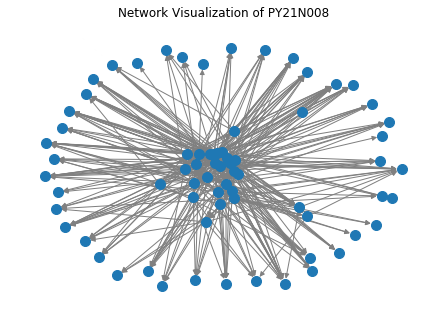

In [76]:
G = nx.DiGraph()
for i in range(D.shape[0]):
    if D.significant.iloc[i] == 1:
        G.add_edge(D.stimChs.iloc[i],D.respChs.iloc[i])

nx.draw(G,node_size = 100, edge_color='grey')
plt.title("Network Visualization of PY21N008")
plt.savefig('Network_PY21N008.png')
plt.show()

In [77]:
G.out_degree()

OutDegreeView({'LFOA1_LFOA2': 30, 'LAH8_LAH9': 7, 'LPH7_LPH8': 4, 'LFOA3_LFOA4': 25, 'LFOA4_LFOA5': 0, 'LFOA5_LFOA6': 0, 'LFOP2_LFOP3': 0, 'LFOP3_LFOP4': 31, 'LFOP5_LFOP6': 9, 'LIN1_LIN2': 7, 'LIN2_LIN3': 0, 'LIN3_LIN4': 27, 'LIN4_LIN5': 0, 'LIN5_LIN6': 0, 'LIN6_LIN7': 0, 'LIN7_LIN8': 0, 'LIN8_LIN9': 24, 'LIN9_LIN10': 0, 'LIN10_LIN11': 16, 'LIN11_LIN12': 0, 'LOF1_LOF2': 9, 'LOF2_LOF3': 0, 'LOF3_LOF4': 14, 'LOF4_LOF5': 0, 'LOF7_LOF8': 0, 'LOF8_LOF9': 0, 'LOF9_LOF10': 0, 'LOF10_LOF11': 0, 'LOF11_LOF12': 0, 'LOF12_LOF13': 22, 'LOF13_LOF14': 0, 'LPH5_LPH6': 9, 'LPH8_LPH9': 0, 'LBT3_LBT4': 10, 'LBT4_LBT5': 0, 'LBT5_LBT6': 0, 'LBT6_LBT7': 11, 'RA5_RA6': 0, 'RA3_RA4': 5, 'RA1_RA2': 14, 'RA9_RA10': 6, 'RAH2_RAH3': 0, 'LA3_LA4': 0, 'LAH3_LAH4': 0, 'LPH2_LPH3': 0, 'LFOA2_LFOA3': 0, 'LPH1_LPH2': 18, 'LAH1_LAH2': 16, 'LAH2_LAH3': 0, 'LAH4_LAH5': 0, 'LAH5_LAH6': 0, 'LBT7_LBT8': 0, 'RAH3_RAH4': 3, 'RAH5_RAH6': 0, 'RAH9_RAH10': 3, 'LOF5_LOF6': 0, 'LOF6_LOF7': 0, 'LTP2_LTP3': 0, 'LBT1_LBT2': 16, 'RAH6

In [87]:
G.in_degree()

InDegreeView({'LFOA1_LFOA2': 10, 'LAH8_LAH9': 9, 'LPH7_LPH8': 8, 'LFOA3_LFOA4': 6, 'LFOA4_LFOA5': 8, 'LFOA5_LFOA6': 8, 'LFOP2_LFOP3': 5, 'LFOP3_LFOP4': 5, 'LFOP5_LFOP6': 6, 'LIN1_LIN2': 10, 'LIN2_LIN3': 6, 'LIN3_LIN4': 6, 'LIN4_LIN5': 8, 'LIN5_LIN6': 10, 'LIN6_LIN7': 10, 'LIN7_LIN8': 5, 'LIN8_LIN9': 5, 'LIN9_LIN10': 5, 'LIN10_LIN11': 6, 'LIN11_LIN12': 10, 'LOF1_LOF2': 12, 'LOF2_LOF3': 9, 'LOF3_LOF4': 6, 'LOF4_LOF5': 15, 'LOF7_LOF8': 8, 'LOF8_LOF9': 12, 'LOF9_LOF10': 10, 'LOF10_LOF11': 11, 'LOF11_LOF12': 3, 'LOF12_LOF13': 7, 'LOF13_LOF14': 3, 'LPH5_LPH6': 0, 'LPH8_LPH9': 6, 'LBT3_LBT4': 5, 'LBT4_LBT5': 5, 'LBT5_LBT6': 6, 'LBT6_LBT7': 8, 'RA5_RA6': 6, 'RA3_RA4': 0, 'RA1_RA2': 2, 'RA9_RA10': 3, 'RAH2_RAH3': 2, 'LA3_LA4': 7, 'LAH3_LAH4': 7, 'LPH2_LPH3': 6, 'LFOA2_LFOA3': 6, 'LPH1_LPH2': 3, 'LAH1_LAH2': 2, 'LAH2_LAH3': 4, 'LAH4_LAH5': 6, 'LAH5_LAH6': 6, 'LBT7_LBT8': 3, 'RAH3_RAH4': 3, 'RAH5_RAH6': 11, 'RAH9_RAH10': 8, 'LOF5_LOF6': 8, 'LOF6_LOF7': 15, 'LTP2_LTP3': 5, 'LBT1_LBT2': 0, 'RAH6_RA

In [90]:
nx.eigenvector_centrality(G)

{'LFOA1_LFOA2': 0.19855836563331525,
 'LAH8_LAH9': 0.08549115745667452,
 'LPH7_LPH8': 0.09983860038395649,
 'LFOA3_LFOA4': 0.13767911599666724,
 'LFOA4_LFOA5': 0.15514174460209976,
 'LFOA5_LFOA6': 0.2017183001859812,
 'LFOP2_LFOP3': 0.10151721464477606,
 'LFOP3_LFOP4': 0.11811428371970342,
 'LFOP5_LFOP6': 0.13124434692678866,
 'LIN1_LIN2': 0.12796484839915648,
 'LIN2_LIN3': 0.14329759419061858,
 'LIN3_LIN4': 0.13742808650542293,
 'LIN4_LIN5': 0.1707429417140197,
 'LIN5_LIN6': 0.21280428233641577,
 'LIN6_LIN7': 0.19140068006622565,
 'LIN7_LIN8': 0.13180403786585268,
 'LIN8_LIN9': 0.13180403786585268,
 'LIN9_LIN10': 0.10683629549851312,
 'LIN10_LIN11': 0.14877768584315396,
 'LIN11_LIN12': 0.1835006417543471,
 'LOF1_LOF2': 0.21068378109183108,
 'LOF2_LOF3': 0.15362113530209762,
 'LOF3_LOF4': 0.09857405362308154,
 'LOF4_LOF5': 0.2629368900174133,
 'LOF7_LOF8': 0.19843880163089223,
 'LOF8_LOF9': 0.24312768363364692,
 'LOF9_LOF10': 0.22340654400346166,
 'LOF10_LOF11': 0.18178419202029356,
 '

In [32]:
df = pd.DataFrame()
df["Nodes"]= pd.DataFrame.from_dict(G.out_degree)[0]
df["Out_Degree"] = pd.DataFrame.from_dict(G.out_degree)[1]
df["In_Degree"] = pd.DataFrame.from_dict(G.in_degree)[1]
df.sort_values(['Out_Degree'])

,Nodes,Out_Degree,In_Degree
35,LBT5_LBT6,0,6
23,LOF4_LOF5,0,15
24,LOF7_LOF8,0,8
25,LOF8_LOF9,0,12
26,LOF9_LOF10,0,10
...,...,...,...
3,LFOA3_LFOA4,25,6
11,LIN3_LIN4,27,6
60,LFOP1_LFOP2,29,5
0,LFOA1_LFOA2,30,10


In [ ]:
Nodes = df.Nodes.tolist()
In_Degree = df.In_Degree.tolist()
Out_Degree = df.Out_Degree.tolist()
plt.figure(figsize=(10,15))
plt.barh(Nodes,In_Degree)
plt.savefig('InDegree_PY21N008')

In [ ]:
plt.figure(figsize=(10,15))
plt.barh(Nodes,Out_Degree)